<a href="https://colab.research.google.com/github/JulianSchmidtke/CAPTUM/blob/main/AsuD_CAPTUM_v0.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import nltk, os
import pandas as pd
import numpy as np
import re
from collections import Counter
import shutil

In [3]:
os.chdir(r'/content')

content_dir = r'/content/CAPTUM/'

# Remove if files already exist
while os.path.exists(content_dir): 
    shutil.rmtree(content_dir)


!git clone https://github.com/JulianSchmidtke/CAPTUM.git

Cloning into 'CAPTUM'...
remote: Enumerating objects: 532, done.
remote: Counting objects: 100% (532/532), done.
remote: Compressing objects: 100% (509/509), done.
remote: Total 532 (delta 38), reused 463 (delta 20), pack-reused 0
Receiving objects: 100% (532/532), 11.47 MiB | 9.84 MiB/s, done.
Resolving deltas: 100% (38/38), done.


# Duplikate unter den Papern entfernen anhand der Hash-Werte

In [4]:
#Arbeitsverzeichnis auf das Ordnerverzeichnis ändern, in welchem die Daten liegen (txt-Format)
file_dir = r'/content/CAPTUM/files'
os.chdir(file_dir)

#Speichern der Dateinamen in einem Array
files = os.listdir()
df_files = pd.DataFrame(files, columns=['Filepath'])

In [5]:
# create checksum for each file to identify duplicates
# https://stackoverflow.com/questions/16874598/how-do-i-calculate-the-md5-checksum-of-a-file-in-python#16876405
import hashlib
def get_checksum(filepath: str) -> str:
    # Open,close, read file and calculate MD5 on its contents 
    with open(filepath, 'rb') as file_to_check:
        # read contents of the file
        data = file_to_check.read()    
        # pipe contents of the file through
        return hashlib.md5(data).hexdigest()
df_files['Checksum'] = df_files['Filepath'].apply(get_checksum)

In [6]:
fileNameTags = list(map(lambda fn: fn.replace('', '+').split('_')[0:-2],df_files['Filepath']))


df_files['Name'] = [fNT[-1] for fNT in fileNameTags]
df_files['Tags'] = [fNT[1:-1] for fNT in fileNameTags]
df_files['Year'] = [fY[-8:-4] for fY in df_files['Name']]
df_files['Authors'] = [fN.split(' ')[0] for fN in df_files['Name']]

In [7]:
#Den Inhalt der Paper einlesen und in einen Pandas-
df_files['Content'] = df_files['Filepath'].apply(lambda f: open(f, 'r', encoding = "ISO-8859-1").read())
df_files

,Filepath,Checksum,Name,Tags,Year,Authors,Content
0,CAPTUM_Total IgE_Basophil_Deza 2017.pdf_out_te...,1a5c1b616c12e9b9771c99e6ceb8d214,Deza 2017.pdf,"[Total IgE, Basophil]",2017,Deza,Acta Dermato-Venereologica\n\nBB\nFE\n(=)\n2\n...
1,CAPTUM_Basophil_Severity_Baker 2008.pdf_out_te...,15a8b0fa0fc3869d149432646287f160,Baker 2008.pdf,"[Basophil, Severity]",2008,Baker,\n\nBasophil histamine release activity and d...
2,CAPTUM_Duration_Angioedema_Ertaş 2019.pdf_out_...,bc1c62415ef1fb6dd2b1395c6d3e69e5,Ertaş 2019.pdf,"[Duration, Angioedema]",2019,Ertaş,Journal Pre-proof ei EI\n\nIn Practice\n\noy\n...
3,CAPTUM_Antihistamine_Omalizumab_Kaplan 2013.pd...,be8146576eb424a59298b6bcc1d73336,Kaplan 2013.pdf,"[Antihistamine, Omalizumab]",2013,Kaplan,Atopic dermatitis and skin disease\n\nOmalizum...
4,CAPTUM_Total IgE_Allergic Diseases_Fang 2018.p...,d67db3ca3de5d6f7eaee3aa9a6094d1c,Fang 2018.pdf,"[Total IgE, Allergic Diseases]",2018,Fang,Clinical Allergy - Research Article\n\nInterna...
...,...,...,...,...,...,...,...
1041,CAPTUM_BAT_Angioedema_Swerdt 2005.pdf_out_text...,cfc0bafeca8e44c8ae4b20db99d3f4d8,Swerdt 2005.pdf,"[BAT, Angioedema]",2005,Swerdt,youpuap AB1a]|p poo\n\nS\nw\no\na\nw\n®\nY\na...
1042,CAPTUM_CRP_Duration_Varghese 2016.pdf_out_text...,2f9977f9c58ea47f2a49853d5c34f077,Varghese 2016.pdf,"[CRP, Duration]",2016,Varghese,Ann Allergy Asthma Immunol xxx (2016) 15\n\n ...
1043,CAPTUM_Total IgE_Eosinophil_El-Azim 2011.pdf_o...,4d231ac53ff1df520d8c049ce58c65ca,El-Azim 2011.pdf,"[Total IgE, Eosinophil]",2011,El-Azim,ORIGINAL ARTICLE\n\nChronic Autoimmune Urticar...
1044,CAPTUM_Total IgE_TPO_Aversano 2005.pdf_out_tex...,7fbce933cdf14bac4456e26c9aa3776b,Aversano 2005.pdf,"[Total IgE, TPO]",2005,Aversano,Allergy 2005: 60: 489-493\n\nOriginal article\...


In [8]:
checksums = df_files['Checksum'].unique()
for checksum in checksums:
    tags = df_files.loc[df_files['Checksum'] == checksum, 'Tags']
    list_of_pair_of_tags = tags.values.ravel()
    list_of_tags = [tag for tags in list_of_pair_of_tags for tag in tags]
    unique_tags = pd.unique(list_of_tags)
    df_files.loc[df_files['Checksum'] == checksum, 'Tags'] = ', '.join(map(str, unique_tags))

In [9]:
# create dataframe for further analytics w/o the duplicate articles
df = df_files.drop_duplicates(subset=['Checksum'], keep='first')
df.reset_index(inplace=True, drop=True)
df = df.loc[:,['Authors','Year','Tags', 'Content']]

# Korpus erstellen

In [10]:
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Es werden Füllwörter entfernt.

In [11]:
stop_words=set(stopwords.words("english"))
def stoppingFunc(text, stop_words=stop_words):
    filtered_text=[]
    for word in text:
        # Wort unter 3 Zeichen -> weg
        if len(word) < 3:
          next
        # Mehr als eine Ziffer -> weg
        elif sum(c.isdigit() for c in word)>1:
          next
        # nicht in Stopword Liste -> behalten
        elif word not in stop_words:
          filtered_text.append(word)
        
    return filtered_text

Wörter auf ihren Wortstamm reduzieren (cats -> cat, transportation -> transport)

In [12]:
def stemmingFunc(text):
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in text]

Komplexere Version des Stemming. Wörter werden im Zusammenhang gesehen und reduziert. Verben werden auf den Infiitiv gesetzt usw.

In [13]:
def lemmatizingFunc(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in text]

In [14]:
def removeWords(text):
  filtered_text=[]
  for word in text:
    if word.lower() in ('csu', 'urticaria', 'doi', 'http', 'the', 'al', 'fig', 
                        'point', 'data', 'patient', 'result', 'study', 'disease', 
                        'result', 'group', 'table', 'figure', 'patient'):
      next
    else:
      filtered_text.append(word)

  counter = Counter(filtered_text)
  filtered_text = [key for key, val in counter.items() if val > 1]

  return filtered_text

In [15]:
def remove_doi(text):
  doi_regex = r"10.\d{4,9}\/[-._;()\/:A-Z0-9]+$"
  new_text = re.sub(doi_regex, '', text, flags=re.IGNORECASE)
  return new_text

In [16]:
removeWords(['csu', 'TEST', 'DOI', 'doi', 'al', 'DOI'])

[]

In [17]:
def normalize_text(tokenizer, text):
  # lowercase text
  text = str(text).lower()
  # remove non-UTF
  text = text.encode("utf-8", "ignore").decode()
  # remove doi
  text = remove_doi(text)

  tokenized_text = tokenizer.tokenize(text)

  tokenized_text = removeWords(tokenized_text)
  tokenized_text = stoppingFunc(tokenized_text)
  #tokenized_text = stemmingFunc(tokenized_text)
  tokenized_text = lemmatizingFunc(tokenized_text)

  text = " ".join(tokenized_text)
  return text

In [18]:
def remove_word_in_every_corpus(corpus, series):
  words = set(series)
  print(words)
  return




  new_corpus = []
  for word in corpus:
    in_every_corpus = True
    for element in series:
      if not word in element:
        in_every_corpus = False
    if in_every_corpus:
      new_corpus += word
  return new_corpus

Ich glaube es sollte entweder eine Stemming oder eine Lemmatizing Funktion angewendet werden.

Ich glaube wir sollten erst Lemmatizen und dann Stopwords entfernen.

In [19]:
regex_tokenizer = nltk.RegexpTokenizer("\w+")
df['Corpus'] = df['Content'].apply(lambda c: normalize_text(regex_tokenizer, c))

# Corpus aufräumen 
#df['Corpus'] = df['Corpus'].apply(lambda c: remove_word_in_every_corpus(c, df['Content']))


regex_tokenizer2 = nltk.RegexpTokenizer('\w+[\.,]{0,1}')
df['Corpus_w_Punctuation'] = df['Content'].apply(lambda c: normalize_text(regex_tokenizer2, c))


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [67]:
corpus_list = df['Content'].to_list()
remove_word_in_every_corpus('', corpus_list)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [21]:
df

,Authors,Year,Tags,Content,Corpus,Corpus_w_Punctuation
0,Deza,2017,"Total IgE, Basophil, Omalizumab, Duration, All...",Acta Dermato-Venereologica\n\nBB\nFE\n(=)\n2\n...,acta dermato venereologica report basophil fce...,acta dermato venereologica is. report basophil...
1,Baker,2008,"Basophil, Severity, Duration, BHRA",\n\nBasophil histamine release activity and d...,basophil histamine release activity disease se...,basophil histamine release activity disease se...
2,Ertaş,2019,"Duration, Angioedema",Journal Pre-proof ei EI\n\nIn Practice\n\noy\n...,journal practice sexual functioning frequently...,journal practice sexual functioning frequently...
3,Kaplan,2013,"Antihistamine, Omalizumab, anti-FcεRI, Allergi...",Atopic dermatitis and skin disease\n\nOmalizum...,atopic skin disease omalizumab patient symptom...,atopic skin disease omalizumab patient symptom...
4,Fang,2018,"Total IgE, Allergic Diseases, Severity",Clinical Allergy - Research Article\n\nInterna...,clinical allergy research immunology int arch ...,clinical allergy research immunology int arch ...
...,...,...,...,...,...,...
449,Ben-Shoshan,2018,"Severity, Omalizumab",Clinical Commentary Review\n\nManagement of Pe...,clinical review management pediatric chronic s...,clinical review management pediatric chronic s...
450,Asero,2018,"Severity, Omalizumab",DR. RICCARDO ASERO (Orcid ID : 0000-0002-8277-...,riccardo asero article editor efficacy omalizu...,riccardo asero article editor efficacy omalizu...
451,Ferrer,2017,"Severity, Omalizumab",doi:10.1684/ejd.2017.3085\n\nReview\n\nMarta F...,ejd review marta ferrer isabelle boccon gibod ...,ejd. review marta ferrer isabelle boccon gibod...
452,Park,2013,"Total IgE, Eosinophil","Ann Dermatol Vol. 25, No. 4, 2013\n\nhttp://dx...",ann dermatol vol org original article staphylo...,ann dermatol vol. no. org ad. original article...


# Wordcloud


In [71]:
!pip install wordcloud

from wordcloud import WordCloud

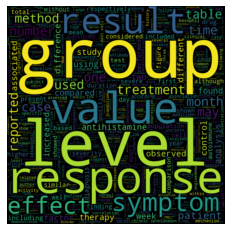

In [56]:
words = ' '.join(list(df['Corpus']))
wordcloud = WordCloud(width=1000, height=1000, max_words=1000).generate(words)
wordcloud.to_file("../../first_review.png")

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Distinct Tags

In [ ]:
type(list(df['Tags']))
tags = set(', '.join(list(df['Tags'])).split(', '))
print(*tags, sep="\n")

Omalizumab
ANA
anti-TPO IgE ratio+
CRP
Antihistamine
dsDNA
Ana
Allergic Diseases
anti-FcεRI
Cyclosporine
BHRA
Basophil count
Eosinophil
duration
Anti-IgE
Basophil
serverity+
thyroglobulin
Duration
angioedema
ASST+
Angioedema
Tissue factor
BAT
cyclosporine
omalizumab
Severity
IL-24
D-Dimer
Eosinophil count
Thyroglobulin
Total IgE
TPO


# Algorithmen anwenden

## Bag of Words
Quelle: [towardsdatascience](https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24)

In [68]:
import gensim
import numpy as np
np.random.seed(2021)
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [69]:
processed_docs = df['Corpus'].apply(lambda c: c.split(' '))

In [70]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 8weeks
1 acad
2 achieve
3 acta
4 action
5 activation
6 active
7 activity
8 addition
9 additional
10 adult


### **LDA** (LatentDirichletAllocation) 
Quelle: [Medium-Artikel zu LDA](https://towardsdatascience.com/nlp-with-lda-latent-dirichlet-allocation-and-text-clustering-to-improve-classification-97688c23d98)

In [ ]:
#Turn tags into a set for faster checking of whether a tag exists or not
type(list(df['Tags']))
unique_tags = set(', '.join(list(df['Tags'])).split(', '))
print(*unique_tags, sep="\n")


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA


def find_topics(text):
  count_vectorizer = CountVectorizer()
  count_data = count_vectorizer.fit_transform(list(text))


  # One topic that has an avg of two words because most questions had 1/2 tags
  number_topics = 5
  number_words = 20

  # Create and fit the LDA model
  lda = LDA(n_components=number_topics, n_jobs=-1)
  lda.fit(count_data)
  words = count_vectorizer.get_feature_names()

  #Get topics from model. They are represented as a list e.g. ['military','army']
  topics = [[words[i] for i in topic.argsort()[:-number_words - 1:-1]] for (topic_idx, topic) in enumerate(lda.components_)]
  topic_groups = topics

  topics = np.array(topics).ravel()
  distinct_topics = list(set(topics))

  #Only use topics for which a tag already exists
  existing_topics = set.intersection(set(topics),unique_tags)

  

  return (words, distinct_topics, topic_groups, existing_topics)

In [ ]:
words, distinct_topics, topic_groups, existing_topics = find_topics(df['Corpus_w_Punctuation'])

In [ ]:
sorted(distinct_topics)


### **BERTopic** 
Topic modeling mit BERTopic -> siehe: https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6

Copy and Paste aus: https://colab.research.google.com/drive/1iqs9Y5_zLI6R6mAwlnapcxcUbKjpv2CC?usp=sharing#scrollTo=MgMaef_uZT0T
bzw.: https://www.youtube.com/watch?v=TLPmlVeEf1k

In [ ]:
!pip3 install bertopic[all]
from bertopic import BERTopic

^C


ModuleNotFoundError: ignored

In [ ]:
topic_model = BERTopic(language="english", calculate_probabilities=True) # We need the probabilities to visualize
topics, _ = topic_model.fit_transform(list(df['Content']))

In [ ]:
# Get the most frequent topics
topic_freq = topic_model.get_topic_freq()
outliers = topic_freq['Count'][topic_freq['Topic']==-1].iloc[0]
print(f"{outliers} documents have not been classified")
print(f"The other {topic_freq['Count'].sum() - outliers} documents are {topic_freq['Topic'].shape[0]-1} topics")

In [ ]:
topic_freq.head()

In [ ]:
print(f"There are {topic_freq['Count'].iloc[1]} documents that are talking about topic ID {topic_freq['Topic'].iloc[1]}")

In [ ]:
topic_model.get_topic(topic_freq['Topic'].iloc[1])

In [ ]:
topic_model.visualize_topics()

### **DistilBert**
Quelle: https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(df['Content'], show_progress_bar=True)

In [ ]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5,
                            metric='cosine').fit_transform(embeddings)

In [ ]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=4,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

In [ ]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=20, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=15)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=15, cmap='hsv_r')
plt.colorbar()

### Top2Vec

Quelle: https://github.com/bhattbhavesh91/Top2Vec-Demo/blob/main/Top2Vec-Notebook.ipynb

In [ ]:
!pip install -q numpy
!pip install -q pandas
!pip install -q gensim
!pip install -q pynndescent>=0.4
!pip install -q umap-learn
!pip install -q hdbscan
!pip install -q wordcloud
!pip install -q tensorflow
!pip install -q tensorflow_hub
!pip install -q tensorflow_text
!pip install -q torch
!pip install -q sentence_transformers
!pip install -q hnswlib
!pip install -q joblib<1.0.0
!pip install -q top2vec[sentence_transformers]

In [ ]:
import numpy as np
import pandas as pd
from copy import deepcopy
from top2vec import Top2Vec

In [ ]:
docs = list(df.loc[:, "Content"].values)
docs[:5]

In [ ]:
model = Top2Vec(docs, embedding_model='universal-sentence-encoder')

In [ ]:
model.get_num_topics()

In [ ]:
topic_words, word_scores, topic_nums = model.get_topics(1)

In [ ]:
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

### TFIDF Vertorizer

In [57]:
tfidfconvert = TfidfVectorizer(ngram_range=(1,1)).fit(df.Corpus.values)

In [58]:
len(tfidfconvert.vocabulary_)

15738

In [59]:
words_transformed = tfidfconvert.transform(df.Corpus.values)

### K-Means Clustering

In [60]:
from sklearn.cluster import KMeans

K-Means für mehrere k's berechnen

In [61]:
Sum_of_squared_distances = []
max_range = 25
K = range(1,max_range + 1)
for k in K: 
    print(str(k) + "/" + str(max_range))
    km = KMeans(n_clusters=k)
    km = km.fit(words_transformed)
    Sum_of_squared_distances.append(km.inertia_)
    

1/25
2/25
3/25
4/25
5/25
6/25
7/25
8/25
9/25
10/25
11/25
12/25
13/25
14/25
15/25
16/25
17/25
18/25
19/25
20/25
21/25
22/25
23/25
24/25
25/25


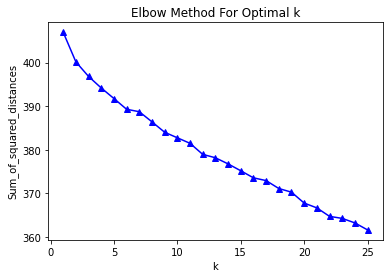

In [62]:
plt.plot(K,Sum_of_squared_distances, 'b^-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()



# **IDEEN zum Cluster bilden**


- Bag of Words kreiren um neuer Cluster / Wortgruppen zu finden über Häufigkeit der Wörter oder nähe der Wörter zu einander
- Visualisieren des Links zwischen Markern in einer HeatMap
- BioBert einsetzen
- Part of Speech recognition um Autorennamen zu identifizieren 
- AutorenNamen und Marker verknüpfen / clustern
- 


**Generelle Todo's**
- Distinct Values für Abkürzungsverzeichnis erheben und mit Markern abgleichen
- CRISP-DM als Vorgehensmoddel zugrundeliegen
- Begründen Stemm / Lemmatizing - Erörterung im Paper